# Histogrammes des Orientations du Gradient

In [14]:
pip install opencv-python-headless numpy matplotlib tqdm scikit-image scikit_learn seaborn


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import pandas as pd
import torchvision.models as models
import torch 
import torch.nn as nn
from PIL import Image


from skimage.feature import hog
from skimage import data, exposure
import sklearn
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import KFold

from copy import deepcopy
import random

In [2]:
data_root_path = "data/UCF-101"

CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES:
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


## Folder Structure

In [3]:
!tree -d

.
└── data
    └── UCF-101
        ├── Biking
        ├── HandstandPushups
        ├── PlayingCello
        ├── PlayingViolin
        └── PushUps

8 directories


In [4]:
## Function to extract frames from a video file
def extract_all_frames_from_video(video_path, frame_rate=3):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to split the video into reference and test sets
# Added seed for reproducibility and to prevent data leaks when re-running cells
def create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75, seed=42):
    reference_set = {}
    test_set = {}
    
    # Set seed for reproducible splits
    random.seed(seed)
    
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        
        groups = set()
        for f in video_files:
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    groups.add(part)
        
        groups = list(groups)
        random.shuffle(groups)
        
        split_index = int(len(groups) * reference_ratio)
        ref_groups = set(groups[:split_index])
        test_groups = set(groups[split_index:])
        
        reference_set[class_name] = []
        test_set[class_name] = []
        
        for f in video_files:
            file_group = None
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    file_group = part
                    break
            
            full_path = os.path.join(class_path, f)
            
            if file_group in ref_groups:
                reference_set[class_name].append(full_path)
            elif file_group in test_groups:
                test_set[class_name].append(full_path)
                
    return reference_set, test_set

## Function to extract the frames from all videos in list of set video paths
def extract_frames_from_video_set(video_path_set, frame_rate=3):
    dataset_frames = {}
    dataset_manifest = {}
    for class_name, video_paths in tqdm(video_path_set.items(), desc="Processing classes"):
        dataset_frames[class_name] = []
        dataset_manifest[class_name] = []
        for video_path in tqdm(video_paths, desc=f"Processing videos in {class_name}", leave=False):
            frames = extract_all_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
            dataset_manifest[class_name].append(len(frames))
    return dataset_frames, dataset_manifest

In [5]:
## using the videos in the data root, we compute some stats about the videos: number of frames, video length, frame size, etc
def compute_video_stats(data_root_path):
    stats = {}
    for class_name in tqdm(CLASS_NAMES, desc="Computing video stats for classes"):
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        num_videos = len(video_files)
        total_frames = 0
        frames = []
        for video_file in tqdm(video_files, desc=f"Processing videos in {class_name}", leave=False):
            video_path = os.path.join(class_path, video_file)
            video_frames = extract_all_frames_from_video(video_path, frame_rate=5)
            total_frames += len(video_frames)
            frames.append(video_frames)
        stats[class_name] = {
            "num_videos": num_videos,
            "total_frames": total_frames,
            "avg_frames_per_video": total_frames / num_videos,
            "min_frames_per_video": min([len(frames) for frames in frames]),
            "max_frames_per_video": max([len(frames) for frames in frames]),
            "avg_frame_size": np.mean([frame.shape for frames in frames for frame in frames], axis=0),
            "min_frame_size": np.min([frame.shape for frames in frames for frame in frames], axis=0),
            "max_frame_size": np.max([frame.shape for frames in frames for frame in frames], axis=0),
            "avg_video_length_sec": np.mean([len(frames)/5 for frames in frames]),
            "min_video_length_sec": min([len(frames)/5 for frames in frames]),
            "max_video_length_sec": max([len(frames)/5 for frames in frames]),
        }
    return stats

compute_video_stats(data_root_path)

Computing video stats for classes:   0%|          | 0/5 [00:00<?, ?it/s]

Computing video stats for classes: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


{'Biking': {'num_videos': 134,
  'total_frames': 6109,
  'avg_frames_per_video': 45.58955223880597,
  'min_frames_per_video': 21,
  'max_frames_per_video': 120,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(9.117910447761194),
  'min_video_length_sec': 4.2,
  'max_video_length_sec': 24.0},
 'HandstandPushups': {'num_videos': 128,
  'total_frames': 3007,
  'avg_frames_per_video': 23.4921875,
  'min_frames_per_video': 10,
  'max_frames_per_video': 51,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(4.6984375),
  'min_video_length_sec': 2.0,
  'max_video_length_sec': 10.2},
 'PlayingCello': {'num_videos': 164,
  'total_frames': 7597,
  'avg_frames_per_video': 46.323170731707314,
  'min_frames_per_video': 21,
  'max_frames_per_video': 83,
  'av

In [6]:
def get_all_dataset_paths(data_root_path):
    dataset_paths = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)

        files = sorted([f for f in os.listdir(class_path) if f.endswith('.avi')])
        dataset_paths[class_name] = [os.path.join(class_path, f) for f in files]
    return dataset_paths

all_path_set = get_all_dataset_paths(data_root_path)

def get_subset_from_indices(features_dict, manifest_dict, indices_dict):
    """
    Reconstructs a subset of features and manifest based on video indices per class.
    """
    subset_features = {}
    subset_manifest = {}
    
    for class_name, indices in indices_dict.items():
        subset_features[class_name] = []
        subset_manifest[class_name] = []
        
        counts = manifest_dict[class_name]
        
        current_idx = 0
        video_slices = []
        for count in counts:
            video_slices.append((current_idx, current_idx + count))
            current_idx += count
            
        full_features = features_dict[class_name]
        
        for vid_idx in indices:
            start, end = video_slices[vid_idx]
            vid_feats = full_features[start:end]
            
            subset_features[class_name].extend(vid_feats)
            subset_manifest[class_name].append(len(vid_feats))
            
    return subset_features, subset_manifest

# créer les K folds
def generate_group_folds(path_set, n_splits=5, seed=42):
    folds = [] # List de dicts: {'train': {class: [indices]}, 'test': {class: [indices]}}
    
    for _ in range(n_splits):
        folds.append({'train': {}, 'test': {}})
        
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for class_name, paths in path_set.items():
        groups_map = {}
        for idx, p in enumerate(paths):
            filename = os.path.basename(p)
            parts = filename.split('_')
            group = None
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    group = part
                    break
            if group:
                if group not in groups_map:
                    groups_map[group] = []
                groups_map[group].append(idx)
        
        unique_groups = sorted(list(groups_map.keys()))
        
        for fold_idx, (train_group_indices, test_group_indices) in enumerate(kf.split(unique_groups)):
            train_groups = [unique_groups[i] for i in train_group_indices]
            test_groups = [unique_groups[i] for i in test_group_indices]
            
            train_video_indices = []
            for g in train_groups:
                train_video_indices.extend(groups_map[g])
                
            test_video_indices = []
            for g in test_groups:
                test_video_indices.extend(groups_map[g])
                
            folds[fold_idx]['train'][class_name] = train_video_indices
            folds[fold_idx]['test'][class_name] = test_video_indices
            
    return folds

cv_folds = generate_group_folds(all_path_set, n_splits=5)
print(f"Generated {len(cv_folds)} folds.")

Generated 5 folds.


In [7]:
print("Extracter les frames:")
all_frames_dataset, all_manifest = extract_frames_from_video_set(all_path_set, frame_rate=1)


Extracter les frames:


Processing classes: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


## HOG Computation

In [8]:

## HOG feature extraction 
def extract_hog_features_for_image(image):
    fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1,
    )
    return fd, hog_image

## HOG Dataset level extraction des features
def extract_hog_features_for_dataset(dataset_frames):
    dataset_hog_features = {}
    for class_name, frames in tqdm(dataset_frames.items(), desc="Extracting HOG features"):
        dataset_hog_features[class_name] = []
        for frame in tqdm(frames, desc=f"Processing frames in {class_name})"):
            fd, hog_image = extract_hog_features_for_image(frame)
            dataset_hog_features[class_name].append((fd, hog_image))
    return dataset_hog_features

In [9]:
print("Créer les features:")
all_hog_features = extract_hog_features_for_dataset(all_frames_dataset)

Créer les features:


Extracting HOG features: 100%|██████████| 5/5 [02:13<00:00, 26.63s/it]


## ResNet Computation

In [10]:
## ResNet extraction des features
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, )
model.fc = nn.Identity()


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)
model.eval()
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

mps


In [11]:
## ResNet Dataset level feature extraction
def compute_resnet_features(train_set, model, preprocess):
    features = {}
    
    with torch.no_grad():
        for class_name, frames in tqdm(train_set.items(), desc="Computing ResNet Features"):
            features_list = []
            batch_size = 32
            batch = []
            for i, frame in enumerate(frames):
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                batch.append(input_tensor)

                if len(batch) == batch_size or i == len(frames) - 1:
                    batch_tensor = torch.cat(batch, dim=0)
                    feature_vectors = model(batch_tensor).cpu().numpy()

                    norms = np.linalg.norm(feature_vectors, axis=1, keepdims=True)
                    feature_vectors = feature_vectors / (norms + 1e-8)

                    features_list.extend(feature_vectors)
                    features[class_name] = [(fv, None) for fv in features_list]  # Store feature vector 
                    batch = [] 
                    
    return features

In [12]:
all_resnet_features = compute_resnet_features(all_frames_dataset, model, preprocess)

Computing ResNet Features: 100%|██████████| 5/5 [01:14<00:00, 14.93s/it]


## Nearest Centroid

In [13]:
## calcule les centroïdes 
def compute_class_averages(features_dataset):
    class_averages = {}
    for class_name, features in features_dataset.items():
        feature_vectors = [fd for fd, hog_image in features]
        average_fd = np.mean(feature_vectors, axis=0)
        class_averages[class_name] = average_fd
    return class_averages

In [14]:
def measure_distance(fd1, fd2):
    return np.linalg.norm(fd1 - fd2)

def classify_frame_centroid(fd, class_hog_averages):
    min_distance = float('inf')
    predicted_class = None
    for class_name, average_fd in class_hog_averages.items():
        distance = measure_distance(fd, average_fd)
        if distance < min_distance:
            min_distance = distance
            predicted_class = class_name
    return predicted_class

def compute_centroid_predictions(features_dataset, class_averages):
    predictions = {}
    for class_name, features in features_dataset.items():
        predictions[class_name] = []
        for fd, hog_image in features:
            predicted_class = classify_frame_centroid(fd, class_averages)
            predictions[class_name].append(predicted_class)
    return predictions

## Evaluation: compute precision, recall and f1 and create confusion matrix
def evaluate_classification(prediction):
    y_true = []
    y_pred = []
    for class_name, predicted_classes in prediction.items():
        y_true.extend([class_name] * len(predicted_classes))
        y_pred.extend(predicted_classes)

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## K-NN

In [15]:
## Compute classification using k-NN approach
def find_k_closest_neighbors(fd, hog_reference_features_dataset, k=5):
    distances = []
    for class_name, features in hog_reference_features_dataset.items():
        for ref_fd, hog_image in features:
            distance = measure_distance(fd, ref_fd)
            distances.append((distance, class_name))
    distances.sort(key=lambda x: x[0])
    return distances[:k]

def majority_vote(neighbors):
    class_votes = {}
    for distance, class_name in neighbors:
        if class_name not in class_votes:
            class_votes[class_name] = 0
        class_votes[class_name] += 1
    sorted_votes = sorted(class_votes.items(), key=lambda x: x[1], reverse=True)
    return sorted_votes[0][0]

def classify_frame_knn(fd, hog_reference_features_dataset, k=5):
    neighbors = find_k_closest_neighbors(fd, hog_reference_features_dataset, k)
    predicted_class = majority_vote(neighbors)
    return predicted_class

def run_knn_prediction(hog_test_features_dataset, hog_reference_features_dataset, k=5):
    predictions = {}
    for class_name, features in hog_test_features_dataset.items():
        predictions[class_name] = []
        for fd, hog_image in features:
            predicted_class = classify_frame_knn(fd, hog_reference_features_dataset, k)
            predictions[class_name].append(predicted_class)
    return predictions


## Video Classification (Voting)
Classify videos by aggregating predictions from individual frames (Majority Voting).

In [16]:
from collections import Counter

def predict_videos_from_frames(features_dataset, video_counts, classify_frame_func):
    video_predictions = {}
    for class_name, counts in video_counts.items():
        video_predictions[class_name] = []
        class_features = features_dataset[class_name]
        
        current_frame_idx = 0
        for count in counts:
            # Extract les features de la video
            video_frame_features = class_features[current_frame_idx : current_frame_idx + count]
            current_frame_idx += count
            
            if not video_frame_features:
                continue

            votes = []
            for feat in video_frame_features:
                # structure des features : (fd, visualization_image) ou (fd, None)
                fd = feat[0]
                pred = classify_frame_func(fd)
                votes.append(pred)
            
            if votes:
                most_common = Counter(votes).most_common(1)[0][0]
                video_predictions[class_name].append(most_common)
            else:
                 video_predictions[class_name].append(class_name) 

    return video_predictions

### Choix de K

Afin de comparer les méthodes entre elles, il nous a fallu fixer une valeur de l'hyperparamètre k pour la méthode de K-NN. Pour cela nous avons fait varier K et observé l'accuracy de chacun des deux modèles (HOG et ResNet) en fonction de ce dernier, dans l'optique de sélectionner pour la suite celui aboutissant aux meilleurs résultats.

Recherche du meilleur K pour HOG (5-Fold CV)
K=1: Accuracy Mean = 0.2804 (std: 0.0554)
K=3: Accuracy Mean = 0.2931 (std: 0.0577)
K=5: Accuracy Mean = 0.3091 (std: 0.0610)
K=7: Accuracy Mean = 0.3313 (std: 0.0669)
K=9: Accuracy Mean = 0.3359 (std: 0.0694)
K=11: Accuracy Mean = 0.3405 (std: 0.0655)
K=13: Accuracy Mean = 0.3452 (std: 0.0619)
K=15: Accuracy Mean = 0.3450 (std: 0.0682)


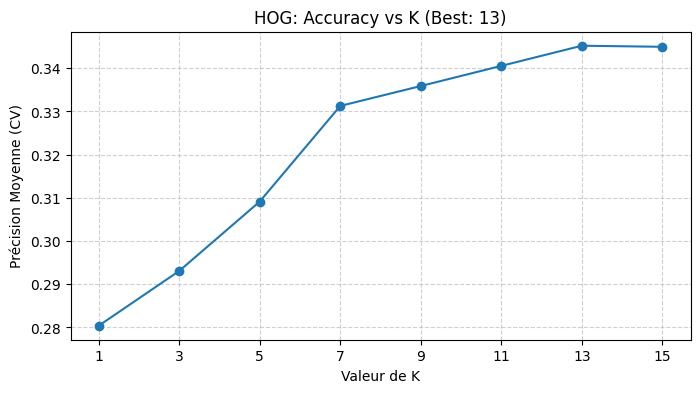

Meilleur K retenu pour HOG : 13
Recherche du meilleur K pour ResNet (5-Fold CV)
K=1: Accuracy Mean = 0.8535 (std: 0.0194)
K=3: Accuracy Mean = 0.8677 (std: 0.0272)
K=5: Accuracy Mean = 0.8599 (std: 0.0259)
K=7: Accuracy Mean = 0.8552 (std: 0.0320)
K=9: Accuracy Mean = 0.8551 (std: 0.0316)
K=11: Accuracy Mean = 0.8534 (std: 0.0276)
K=13: Accuracy Mean = 0.8502 (std: 0.0306)
K=15: Accuracy Mean = 0.8535 (std: 0.0318)


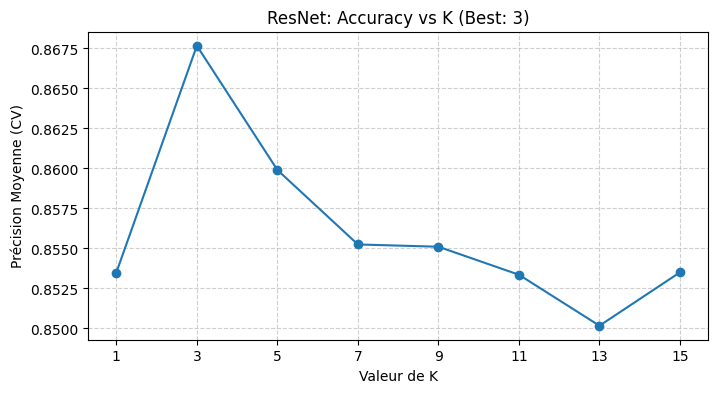

Meilleur K retenu pour ResNet : 3


In [17]:
k_range = [1, 3, 5, 7, 9, 11, 13, 15]

def compute_accuracy_from_predictions(predictions):
    correct = 0
    total = 0
    for true_class, pred_list in predictions.items():
        for pred in pred_list:
            if pred == true_class:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0

def select_best_k_with_cv(k_values, all_features, all_manifest, cv_folds, label="Method"):
    print(f"Recherche du meilleur K pour {label} (5-Fold CV)")
    mean_accuracies = []
    
    for k in k_values:
        fold_scores = []
        
        for fold_idx, fold in enumerate(cv_folds):
            train_idx, test_idx = fold['train'], fold['test']
            
            train_feat, _ = get_subset_from_indices(all_features, all_manifest, train_idx)
            test_feat, test_man = get_subset_from_indices(all_features, all_manifest, test_idx)
            
            # Predict
            current_k = k
            predictor_func = lambda fd, tf=train_feat: classify_frame_knn(fd, tf, k=current_k)
            
            video_predictions = predict_videos_from_frames(
                test_feat, 
                test_man, 
                predictor_func
            )
            
            acc = compute_accuracy_from_predictions(video_predictions)
            fold_scores.append(acc)
            
        avg_acc = np.mean(fold_scores)
        mean_accuracies.append(avg_acc)
        print(f"K={k}: Accuracy Mean = {avg_acc:.4f} (std: {np.std(fold_scores):.4f})")
    
    best_acc = max(mean_accuracies)
    best_k = k_values[mean_accuracies.index(best_acc)]
    
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', label=f'{label} CV Accuracy')
    plt.title(f'{label}: Accuracy vs K (Best: {best_k})')
    plt.xlabel('Valeur de K')
    plt.ylabel('Précision Moyenne (CV)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(k_values)
    plt.show()
    
    return best_k

# Optimisation pour HOG
best_k_hog = select_best_k_with_cv(k_range, all_hog_features, all_manifest, cv_folds, label="HOG")
print(f"Meilleur K retenu pour HOG : {best_k_hog}")

# Optimisation pour ResNet
best_k_resnet = select_best_k_with_cv(k_range, all_resnet_features, all_manifest, cv_folds, label="ResNet")
print(f"Meilleur K retenu pour ResNet : {best_k_resnet}")

Cross-Validation (5 Folds) for HOG + Centroid
Fold 1: Accuracy = 0.6400
Fold 2: Accuracy = 0.5210
Fold 3: Accuracy = 0.5159
Fold 4: Accuracy = 0.5625
Fold 5: Accuracy = 0.4462
HOG + Centroid : CV Results: Mean Accuracy = 0.5371 (+/- 0.0636)

Aggregation des résultats (Matrice de Confusion) pour HOG + Centroid:
                  precision    recall  f1-score   support

          Biking       0.59      0.88      0.71       134
HandstandPushups       0.50      0.52      0.51       128
    PlayingCello       0.52      0.54      0.53       164
   PlayingViolin       0.57      0.46      0.51       100
         PushUps       0.40      0.19      0.25       102

        accuracy                           0.54       628
       macro avg       0.52      0.52      0.50       628
    weighted avg       0.52      0.54      0.52       628



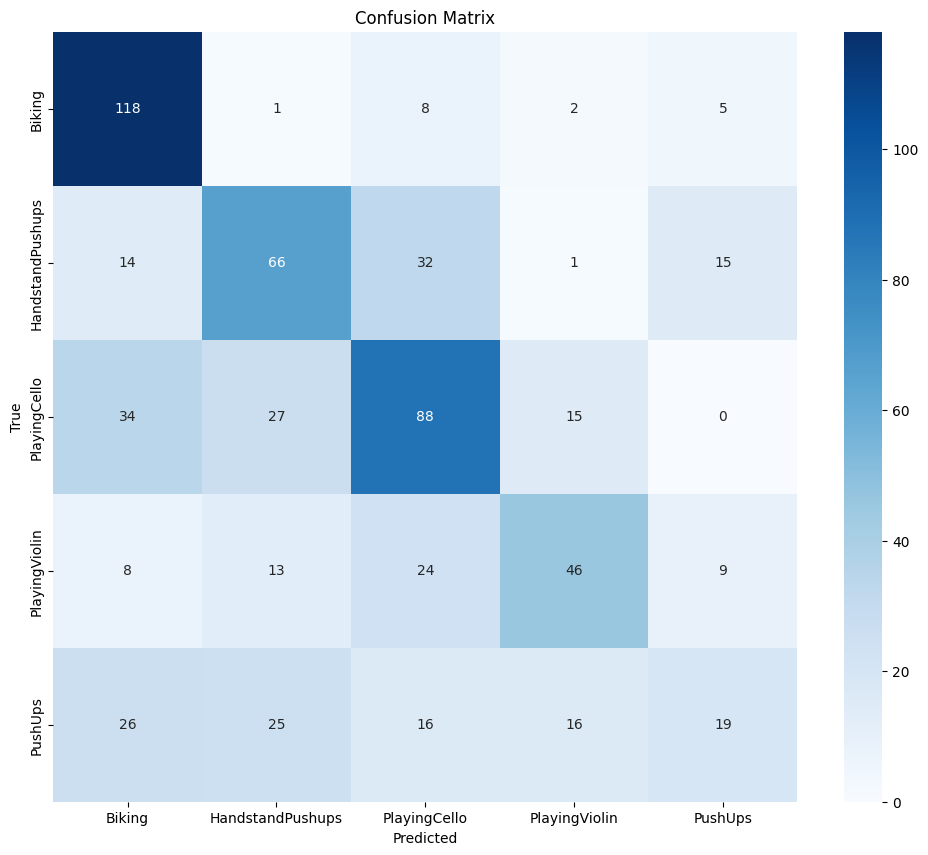

Cross-Validation (5 Folds) for ResNet + Centroid
Fold 1: Accuracy = 0.9360
Fold 2: Accuracy = 0.8571
Fold 3: Accuracy = 0.9683
Fold 4: Accuracy = 0.9453
Fold 5: Accuracy = 0.9077
ResNet + Centroid : CV Results: Mean Accuracy = 0.9229 (+/- 0.0382)

Aggregation des résultats (Matrice de Confusion) pour ResNet + Centroid:
                  precision    recall  f1-score   support

          Biking       0.96      1.00      0.98       134
HandstandPushups       0.89      0.89      0.89       128
    PlayingCello       1.00      0.92      0.96       164
   PlayingViolin       0.88      0.99      0.93       100
         PushUps       0.85      0.80      0.82       102

        accuracy                           0.92       628
       macro avg       0.92      0.92      0.92       628
    weighted avg       0.92      0.92      0.92       628



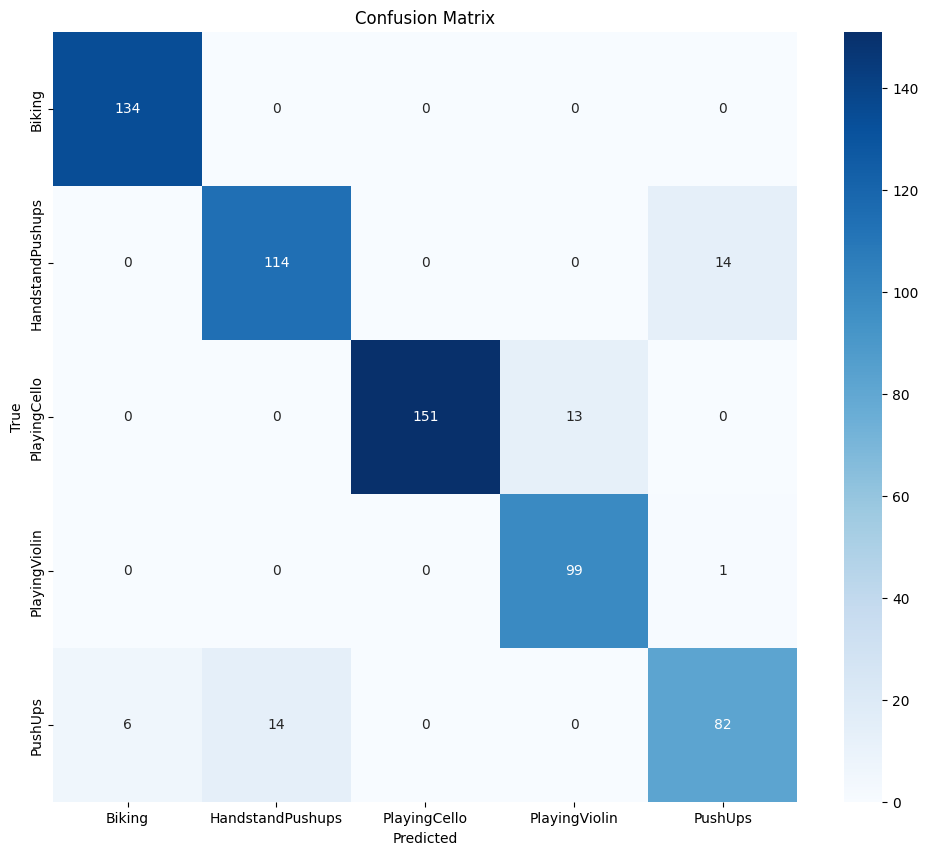

Cross-Validation (5 Folds) for HOG + KNN (k=13)
Fold 1: Accuracy = 0.4080
Fold 2: Accuracy = 0.2773
Fold 3: Accuracy = 0.4286
Fold 4: Accuracy = 0.2891
Fold 5: Accuracy = 0.3231
HOG + KNN (k=13) : CV Results: Mean Accuracy = 0.3452 (+/- 0.0619)

Aggregation des résultats (Matrice de Confusion) pour HOG + KNN (k=13):
                  precision    recall  f1-score   support

          Biking       0.33      0.96      0.49       134
HandstandPushups       0.20      0.02      0.04       128
    PlayingCello       0.60      0.30      0.40       164
   PlayingViolin       0.70      0.16      0.26       100
         PushUps       0.17      0.20      0.18       102

        accuracy                           0.35       628
       macro avg       0.40      0.33      0.27       628
    weighted avg       0.41      0.35      0.29       628



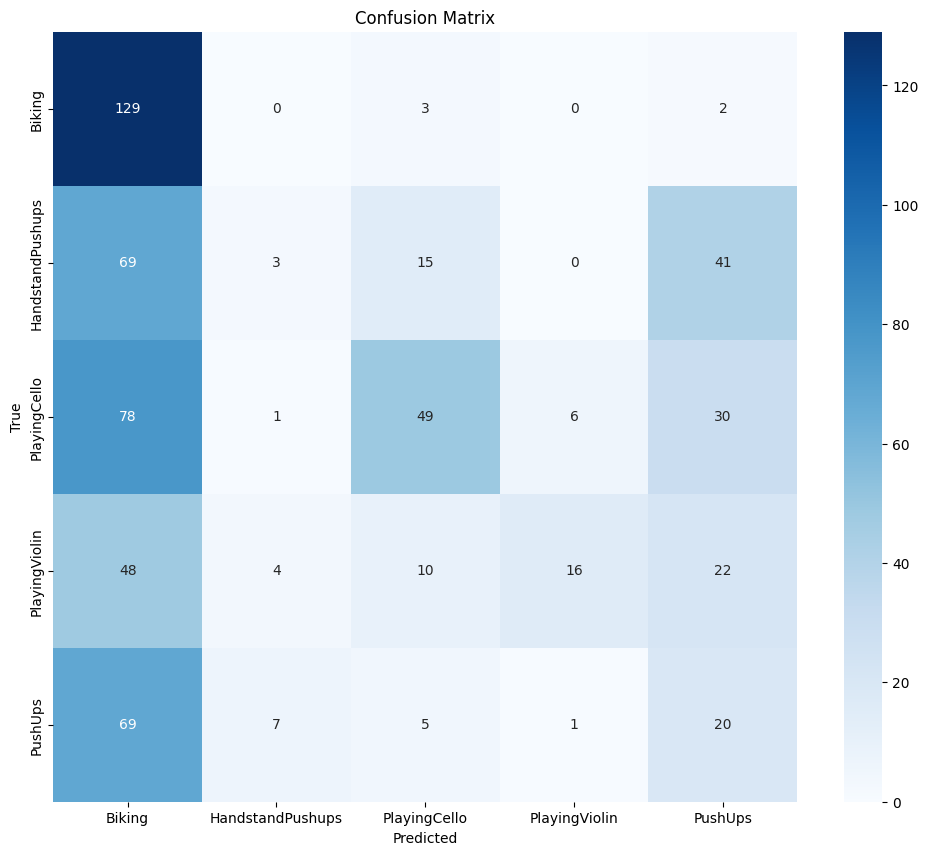

Cross-Validation (5 Folds) for ResNet + KNN (k=3)
Fold 1: Accuracy = 0.8640
Fold 2: Accuracy = 0.8739
Fold 3: Accuracy = 0.8175
Fold 4: Accuracy = 0.8906
Fold 5: Accuracy = 0.8923
ResNet + KNN (k=3) : CV Results: Mean Accuracy = 0.8677 (+/- 0.0272)

Aggregation des résultats (Matrice de Confusion) pour ResNet + KNN (k=3):
                  precision    recall  f1-score   support

          Biking       0.90      1.00      0.95       134
HandstandPushups       0.75      0.81      0.78       128
    PlayingCello       0.98      0.94      0.96       164
   PlayingViolin       0.87      0.97      0.92       100
         PushUps       0.77      0.55      0.64       102

        accuracy                           0.87       628
       macro avg       0.85      0.85      0.85       628
    weighted avg       0.87      0.87      0.86       628



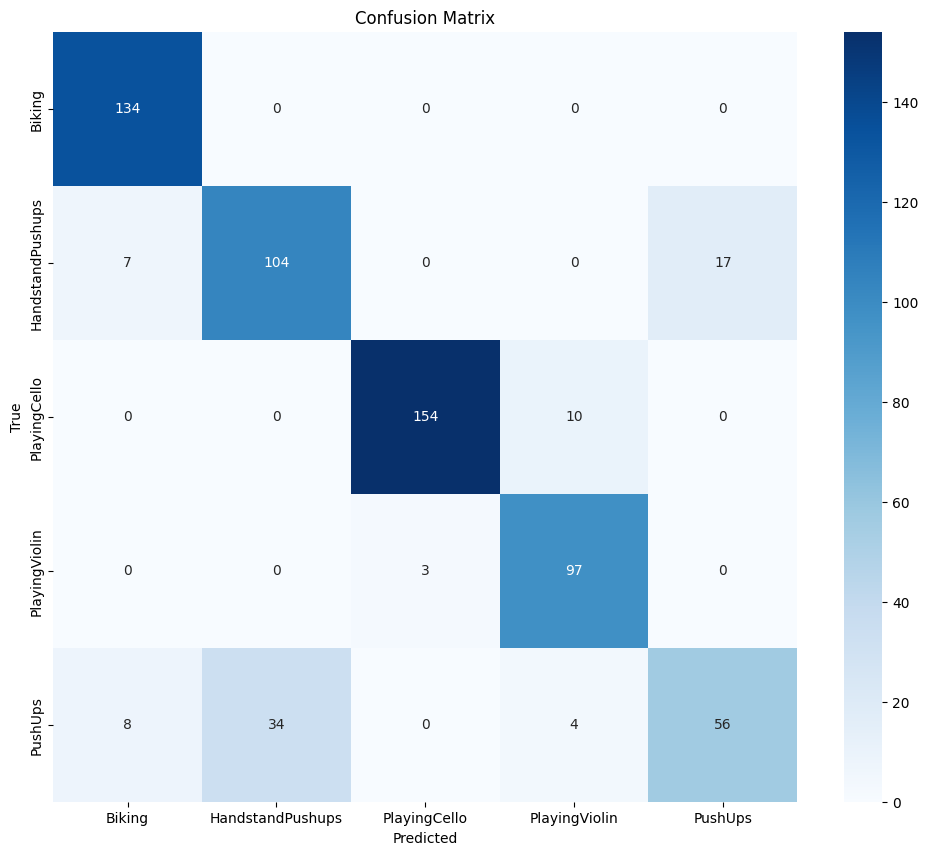

np.float64(0.8676685179199886)

In [20]:
def perform_cross_validation(cv_folds, all_features, all_manifest, method, k=None, label="Method"):
    scores = []
    all_predictions = {}
    print(f"Cross-Validation (5 Folds) for {label}")
    
    for i, fold in enumerate(cv_folds):
        train_idx, test_idx = fold['train'], fold['test']
        
        train_feat, _ = get_subset_from_indices(all_features, all_manifest, train_idx)
        test_feat, test_man = get_subset_from_indices(all_features, all_manifest, test_idx)
        
        predictor = None
        if method == 'centroid':
            class_avgs = compute_class_averages(train_feat)
            predictor = lambda fd: classify_frame_centroid(fd, class_avgs)
        elif method == 'knn':
            predictor = lambda fd: classify_frame_knn(fd, train_feat, k=k)
            
        video_predictions = predict_videos_from_frames(test_feat, test_man, predictor)
        
        # for Global Confusion Matrix
        for class_name, preds in video_predictions.items():
            if class_name not in all_predictions:
                all_predictions[class_name] = []
            all_predictions[class_name].extend(preds)

        acc = compute_accuracy_from_predictions(video_predictions)
        scores.append(acc)
        print(f"Fold {i+1}: Accuracy = {acc:.4f}")
        
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{label} : CV Results: Mean Accuracy = {mean_score:.4f} (+/- {std_score:.4f})")
    
    print(f"\nAggregation des résultats (Matrice de Confusion) pour {label}:")
    evaluate_classification(all_predictions)

    return mean_score

perform_cross_validation(cv_folds, all_hog_features, all_manifest, method='centroid', label="HOG + Centroid")
perform_cross_validation(cv_folds, all_resnet_features, all_manifest, method='centroid', label="ResNet + Centroid")
perform_cross_validation(cv_folds, all_hog_features, all_manifest, method='knn', k=best_k_hog, label=f"HOG + KNN (k={best_k_hog})")
perform_cross_validation(cv_folds, all_resnet_features, all_manifest, method='knn', k=best_k_resnet, label=f"ResNet + KNN (k={best_k_resnet})")

In [21]:

## augmente la luminosité de l'image
def augment_brightness(image, value=50):
    # on passe en HSV pour modifier la composante V (Value) (plus simple)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v, value)
    
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

## augmente geometriquement 
def augment_rotation(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)


In [22]:
all_frames_bright = {}
all_frames_rot = {}

for class_name, frames in all_frames_dataset.items():
    all_frames_bright[class_name] = [augment_brightness(f, value=-50) for f in frames]
    all_frames_rot[class_name] = [augment_rotation(f) for f in frames]

In [23]:
all_hog_bright = extract_hog_features_for_dataset(all_frames_bright)
all_hog_rot = extract_hog_features_for_dataset(all_frames_rot)

all_resnet_bright = compute_resnet_features(all_frames_bright, model, preprocess)
all_resnet_rot = compute_resnet_features(all_frames_rot, model, preprocess)

Extracting HOG features:   0%|          | 0/5 [00:00<?, ?it/s]

Computing ResNet Features: 100%|██████████| 5/5 [02:20<00:00, 28.20s/it]


In [24]:
def run_robustness_cv(cv_folds, train_features, test_features_dict, manifest, method, k=None, label="Method"):
    scores = []
    all_predictions = {}
    print(f"Robustness CV for {label}")
    
    for i, fold in enumerate(cv_folds):
        train_idx, test_idx = fold['train'], fold['test']
        
        # Train on original data
        train_feat, _ = get_subset_from_indices(train_features, manifest, train_idx)
        
        # Test on AUGMENTED data
        test_feat, test_man = get_subset_from_indices(test_features_dict, manifest, test_idx)
        
        predictor = None
        if method == 'centroid':
            class_avgs = compute_class_averages(train_feat)
            predictor = lambda fd: classify_frame_centroid(fd, class_avgs)
        elif method == 'knn':
            predictor = lambda fd: classify_frame_knn(fd, train_feat, k=k)
            
        video_predictions = predict_videos_from_frames(test_feat, test_man, predictor)
        
        # Accumulate predictions
        for class_name, preds in video_predictions.items():
            if class_name not in all_predictions:
                all_predictions[class_name] = []
            all_predictions[class_name].extend(preds)
            
        acc = compute_accuracy_from_predictions(video_predictions)
        scores.append(acc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"Result: Mean Accuracy = {mean_score:.4f} (+/- {std_score:.4f})")
    
    return mean_score

print("\nRobustness Analysis")

# HOG Centroid
run_robustness_cv(cv_folds, all_hog_features, all_hog_bright, all_manifest, 'centroid', label="HOG + Centroid (Brightness)")
run_robustness_cv(cv_folds, all_hog_features, all_hog_rot, all_manifest, 'centroid', label="HOG + Centroid (Rotation)")

# ResNet Centroid
run_robustness_cv(cv_folds, all_resnet_features, all_resnet_bright, all_manifest, 'centroid', label="ResNet + Centroid (Brightness)")
run_robustness_cv(cv_folds, all_resnet_features, all_resnet_rot, all_manifest, 'centroid', label="ResNet + Centroid (Rotation)")

# HOG KNN
run_robustness_cv(cv_folds, all_hog_features, all_hog_bright, all_manifest, 'knn', k=best_k_hog, label=f"HOG + KNN (Brightness)")
run_robustness_cv(cv_folds, all_hog_features, all_hog_rot, all_manifest, 'knn', k=best_k_hog, label=f"HOG + KNN (Rotation)")

# ResNet KNN
run_robustness_cv(cv_folds, all_resnet_features, all_resnet_bright, all_manifest, 'knn', k=best_k_resnet, label=f"ResNet + KNN (Brightness)")
run_robustness_cv(cv_folds, all_resnet_features, all_resnet_rot, all_manifest, 'knn', k=best_k_resnet, label=f"ResNet + KNN (Rotation)")


Robustness Analysis
Robustness CV for HOG + Centroid (Brightness)
Result: Mean Accuracy = 0.5275 (+/- 0.0650)
Robustness CV for HOG + Centroid (Rotation)
Result: Mean Accuracy = 0.2469 (+/- 0.0573)
Robustness CV for ResNet + Centroid (Brightness)
Result: Mean Accuracy = 0.8886 (+/- 0.0627)
Robustness CV for ResNet + Centroid (Rotation)
Result: Mean Accuracy = 0.6853 (+/- 0.0247)
Robustness CV for HOG + KNN (Brightness)
Result: Mean Accuracy = 0.3169 (+/- 0.0625)
Robustness CV for HOG + KNN (Rotation)
Result: Mean Accuracy = 0.2095 (+/- 0.0289)
Robustness CV for ResNet + KNN (Brightness)
Result: Mean Accuracy = 0.8516 (+/- 0.0228)
Robustness CV for ResNet + KNN (Rotation)
Result: Mean Accuracy = 0.7099 (+/- 0.0242)


np.float64(0.7098843675931912)

### Mesure du temps de traitement pour chaque méthode

In [ ]:
# using just Fold 0 (Single Split)
test_indices = cv_folds[0]['test']
train_indices = cv_folds[0]['train']

# test_path_set 
test_path_set = {}
for class_name, indices in test_indices.items():
    test_path_set[class_name] = []
    all_paths = all_path_set[class_name]
    for idx in indices:
        test_path_set[class_name].append(all_paths[idx])

# Training Set
hog_reference_features_dataset, _ = get_subset_from_indices(all_hog_features, all_manifest, train_indices)
resnet_reference_features_dataset, _ = get_subset_from_indices(all_resnet_features, all_manifest, train_indices)

class_hog_averages_reference = compute_class_averages(hog_reference_features_dataset)
class_resnet_averages_reference = compute_class_averages(resnet_reference_features_dataset)

import time
import matplotlib.pyplot as plt
import pandas as pd

methods = ["HOG + Centroid", "HOG + kNN", "ResNet + Centroid", "ResNet + kNN"]
extraction_times = []
classification_times = []
total_times = []

print("Starting performance measurement...")

# HOG Feature Extraction
print("\nMeasuring Path 1: HOG Extraction (Frames + HOG Features)")
start_time = time.time()
hog_frames, hog_manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
hog_features = extract_hog_features_for_dataset(hog_frames)
hog_ext_time = time.time() - start_time
print(f"HOG Extraction Time: {hog_ext_time:.2f}s")

# HOG Classification - Centroid
print("Measuring Path 2: HOG + Centroid Classification")
start_time = time.time()
_ = predict_videos_from_frames(
    hog_features, 
    hog_manifest, 
    lambda fd: classify_frame_centroid(fd, class_hog_averages_reference)
)
hog_cent_class_time = time.time() - start_time
print(f"HOG + Centroid Class. Time: {hog_cent_class_time:.2f}s")

# HOG Classification - KNN
print("Measuring Path 3: HOG + kNN Classification")
start_time = time.time()
_ = predict_videos_from_frames(
    hog_features, 
    hog_manifest, 
    lambda fd: classify_frame_knn(fd, hog_reference_features_dataset, k=5)
)
hog_knn_class_time = time.time() - start_time
print(f"HOG + kNN Class. Time: {hog_knn_class_time:.2f}s")


# ResNet Feature Extraction
print("\nMeasuring Path 4: ResNet Extraction (Frames + ResNet Features)")
start_time = time.time()
resnet_frames, resnet_manifest = extract_frames_from_video_set(test_path_set, frame_rate=1)
resnet_features = compute_resnet_features(resnet_frames, model, preprocess)
resnet_ext_time = time.time() - start_time
print(f"ResNet Extraction Time: {resnet_ext_time:.2f}s")

# ResNet Classification - Centroid
print("Measuring Path 5: ResNet + Centroid Classification")
start_time = time.time()
_ = predict_videos_from_frames(
    resnet_features, 
    resnet_manifest, 
    lambda fd: classify_frame_centroid(fd, class_resnet_averages_reference)
)
resnet_cent_class_time = time.time() - start_time
print(f"ResNet + Centroid Class. Time: {resnet_cent_class_time:.2f}s")

# ResNet Classification - KNN
print("Measuring Path 6: ResNet + kNN Classification")
start_time = time.time()
_ = predict_videos_from_frames(
    resnet_features, 
    resnet_manifest, 
    lambda fd: classify_frame_knn(fd, resnet_reference_features_dataset, k=5)
)
resnet_knn_class_time = time.time() - start_time
print(f"ResNet + kNN Class. Time: {resnet_knn_class_time:.2f}s")

# HOG Ext is shared for both HOG methods, ResNet Ext shared for both ResNet methods
extraction_times = [hog_ext_time, hog_ext_time, resnet_ext_time, resnet_ext_time]
classification_times = [hog_cent_class_time, hog_knn_class_time, resnet_cent_class_time, resnet_knn_class_time]
total_times = [e + c for e, c in zip(extraction_times, classification_times)]


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(methods))

p1 = ax.bar(indices, extraction_times, bar_width, label='Feature Extraction', color='skyblue', edgecolor='white')
p2 = ax.bar(indices, classification_times, bar_width, bottom=extraction_times, label='Classification', color='salmon', edgecolor='white')

ax.set_title('Execution Time Breakdown per Pipeline')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(indices)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add total labels on top
for i, total in enumerate(total_times):
    ax.text(i, total, f'{total:.2f}s', ha='center', va='bottom', fontweight='bold')
    
# Add segment labels if segment is large enough
for i, (ext, cls) in enumerate(zip(extraction_times, classification_times)):
    if ext > 0.05 * max(total_times): 
        ax.text(i, ext/2, f'{ext:.1f}s', ha='center', va='center', color='black', fontsize=9)
    if cls > 0.05 * max(total_times): 
        ax.text(i, ext + cls/2, f'{cls:.1f}s', ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()

# Print Table
results_df = pd.DataFrame({
    "Method": methods,
    "Extraction Time (s)": extraction_times,
    "Classification Time (s)": classification_times,
    "Total Time (s)": total_times
})
print("\nSummary Table:")
print(results_df)

Starting performance measurement...

Measuring Path 1: HOG Extraction (Frames + HOG Features)


Extracting HOG features:  40%|████      | 2/5 [00:08<00:12,  4.27s/it]